# Predicting NYC Taxi Fares with RAPIDS

[RAPIDS](https://rapids.ai/) is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, Dask, and Scikitlearn.

Anaconda has graciously made some of the NYC Taxi dataset available in [a public Google Cloud Storage bucket](https://console.cloud.google.com/storage/browser/anaconda-public-data/nyc-taxi/csv/). We have already cleaned up the column names a bit and re-saved a single month of the data. (For a larger-scale exercise, consider adapting this script to handle a full year via Dask!) We saved the converted version in an S3 bucket here: https://odsc-sample-data.s3-us-west-2.amazonaws.com/yellow_tripdata_2014-03-cleaned.orc.

This notebook builds a simple data pipeline to load the data with cuDF (or Pandas), analyze it with cuML (or scikit-learn), and then try some steps with multiple GPUs.

In [1]:
import numpy as np
import pandas as pd
import cuml
import cudf
import os
import gc

# Demo 1: Inspecting the Data

Let's start with a familiar Pandas approach then port it to RAPIDS in parallel. Note that both Pandas and cuDF can read directly from an S3 bucket. If you're going to re-run this example many times or run outside of AWS, consider saving the file locally (it's about 400MB).

In [2]:
%%time
# Pandas

max_rows = 100000
# df = pd.read_orc('yellow_tripdata_2014-03-cleaned.orc') # Alternative for local read
df = pd.read_orc('https://odsc-sample-data.s3-us-west-2.amazonaws.com/yellow_tripdata_2014-03-cleaned.orc')

if max_rows:
    # Shrink the data for low memory instances
    df = df.iloc[:max_rows]
df.head()

CPU times: user 2.4 s, sys: 1.66 s, total: 4.06 s
Wall time: 22 s


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-03-01 01:07:38,2014-03-01 01:16:26,1,2.0,-73.951508,40.714111,1,-73.944275,40.690678,9.0
1,2014-03-01 01:08:03,2014-03-01 01:12:51,2,1.2,-74.004738,40.742172,1,-73.992226,40.748211,6.0
2,2014-03-01 01:08:51,2014-03-01 01:13:18,3,0.5,-73.949303,40.707569,1,-73.951653,40.714249,5.0
3,2014-03-01 01:09:20,2014-03-01 01:24:18,3,3.5,-73.993538,40.721298,1,-73.961433,40.760410,14.0
4,2014-03-01 01:09:46,2014-03-01 01:22:34,1,1.8,-73.987885,40.744579,1,-74.004387,40.722775,10.5


In [3]:
%%time
# TODO: Read the CSV with cudf into 'gdf' and display the first few rows

# *** Answer: ***

# gdf = cudf.read_orc('yellow_tripdata_2014-03-cleaned.orc')
gdf = cudf.read_orc('https://odsc-sample-data.s3-us-west-2.amazonaws.com/yellow_tripdata_2014-03-cleaned.orc')

gdf.head()

CPU times: user 4.26 s, sys: 2.07 s, total: 6.33 s
Wall time: 26.1 s


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-03-01 01:07:38,2014-03-01 01:16:26,1,2.0,-73.951508,40.714111,1,-73.944275,40.690678,9.0
1,2014-03-01 01:08:03,2014-03-01 01:12:51,2,1.2,-74.004738,40.742172,1,-73.992226,40.748211,6.0
2,2014-03-01 01:08:51,2014-03-01 01:13:18,3,0.5,-73.949303,40.707569,1,-73.951653,40.714249,5.0
3,2014-03-01 01:09:20,2014-03-01 01:24:18,3,3.5,-73.993538,40.721298,1,-73.961433,40.760410,14.0
4,2014-03-01 01:09:46,2014-03-01 01:22:34,1,1.8,-73.987885,40.744579,1,-74.004387,40.722775,10.5


# Look at some key stats

When passing data to functions that expect Pandas DataFrames, we just use ".to_pandas()"

<AxesSubplot:xlabel='passenger_count', ylabel='fare_amount'>

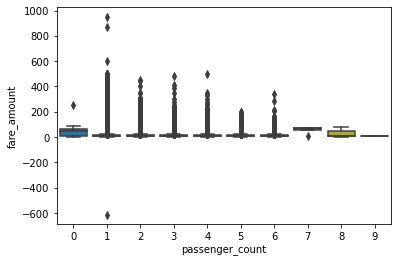

In [4]:
import seaborn as sns

sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

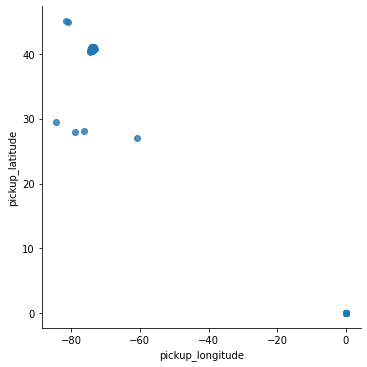

In [5]:
sns.lmplot(x="pickup_longitude", y="pickup_latitude",
           data=gdf.head(100000).to_pandas(),
           fit_reg=False,
           x_jitter=0.01, y_jitter=0.01)

# Filter the data

Ok, there are some WEIRD latitudes and longitudes in that data. Let's filter to just sane stuff.

In [6]:
%%time

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75.0 and pickup_longitude < -73.0',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42'
]
df_subset = df.query(' and '.join(query_frags)).copy()

# inspect the results of cleaning
df_subset.head()
df = None

CPU times: user 9.93 ms, sys: 4.81 ms, total: 14.7 ms
Wall time: 14.9 ms


In [7]:
%%time

# TODO: RAPIDS version with "gdf_subset" as output

# *** Answer:
gdf_subset = gdf.query(' and '.join(query_frags)).copy()
gdf_subset.head()

CPU times: user 368 ms, sys: 40.5 ms, total: 409 ms
Wall time: 717 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-03-01 01:07:38,2014-03-01 01:16:26,1,2.0,-73.951508,40.714111,1,-73.944275,40.690678,9.0
1,2014-03-01 01:08:03,2014-03-01 01:12:51,2,1.2,-74.004738,40.742172,1,-73.992226,40.748211,6.0
2,2014-03-01 01:08:51,2014-03-01 01:13:18,3,0.5,-73.949303,40.707569,1,-73.951653,40.714249,5.0
3,2014-03-01 01:09:20,2014-03-01 01:24:18,3,3.5,-73.993538,40.721298,1,-73.961433,40.760410,14.0
4,2014-03-01 01:09:46,2014-03-01 01:22:34,1,1.8,-73.987885,40.744579,1,-74.004387,40.722775,10.5


# Demo 2: UDFs to add rich features (more advanced topic)

cuDF provides standard DataFrame operations, but also let you run "user defined functions" on the underlying data. For simple operations on a single column, you can just pass in a standard Python function or lambda.

cuDF's [apply_rows](https://docs.rapids.ai/api/cudf/stable/guide-to-udfs.html#DataFrame-UDFs) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels. This allows you to port complex functions that use multiple columns from the DataFrame.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [8]:
from numpy import pi

def haversine_distance_kernel_cpu(row):
    x_1, y_1, x_2, y_2 = (row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"])
    x_1 = pi/180 * x_1
    y_1 = pi/180 * y_1
    x_2 = pi/180 * x_2
    y_2 = pi/180 * y_2

    dlon = y_2 - y_1
    dlat = x_2 - x_1
    a = np.sin(dlat/2)**2 + np.cos(x_1) * np.cos(x_2) * np.sin(dlon/2)**2

    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
        
    return c * r
        
def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df['pickup_latitude_r'] = df['pickup_latitude']//.01*.01
    df['pickup_longitude_r'] = df['pickup_longitude']//.01*.01
    df['dropoff_latitude_r'] = df['dropoff_latitude']//.01*.01
    df['dropoff_longitude_r'] = df['dropoff_longitude']//.01*.01
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df

In [9]:
%%time

# actually add the features
taxi_df = add_features(df_subset)
df_subset = None # free up some memory

CPU times: user 67.4 ms, sys: 273 µs, total: 67.7 ms
Wall time: 67.2 ms


In [10]:
%%time
# compute distance
taxi_df["h_distance"] = haversine_distance_kernel_cpu(taxi_df)

CPU times: user 4.56 ms, sys: 150 µs, total: 4.71 ms
Wall time: 4.61 ms


## cuDF version with UDF

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

In [11]:
import math
from math import cos, sin, asin, sqrt, pi

def haversine_distance_kernel_gpu(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi/180 * x_1
        y_1 = pi/180 * y_1
        x_2 = pi/180 * x_2
        y_2 = pi/180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat/2)**2 + cos(x_1) * cos(x_2) * sin(dlon/2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Radius of earth in kilometers
        
        h_distance[i] = c * r
  
def add_features_gpu(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df['pickup_latitude_r'] = df['pickup_latitude']//.01*.01
    df['pickup_longitude_r'] = df['pickup_longitude']//.01*.01
    df['dropoff_latitude_r'] = df['dropoff_latitude']//.01*.01
    df['dropoff_longitude_r'] = df['dropoff_longitude']//.01*.01
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    
 
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df

def compute_distance_gpu(df):
    df = df.apply_rows(haversine_distance_kernel_gpu,
                   incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
                   outcols=dict(h_distance=np.float32),
                   kwargs=dict())
    return df

In [12]:
%%time

# TODO: actually add the features and create "taxi_gdf" from gdf_subset

# Answer
taxi_gdf = add_features_gpu(gdf_subset)

CPU times: user 36.8 ms, sys: 20.6 ms, total: 57.4 ms
Wall time: 278 ms


In [13]:
%%time

# TODO: add the distance calculation

# *** Answer
taxi_gdf = compute_distance_gpu(taxi_gdf)

CPU times: user 375 ms, sys: 27.1 ms, total: 403 ms
Wall time: 432 ms


For more advanced spatial calculations, check out cuSpatial (https://medium.com/rapids-ai/releasing-cuspatial-to-accelerate-geospatial-and-spatiotemporal-processing-b686d8b32a9), the newest RAPIDS library.

In [14]:
%%time

# TODO: Print summary stats from "taxi_gdf"

# *** Answer:
taxi_gdf.describe()

CPU times: user 1.23 s, sys: 55.9 ms, total: 1.29 s
Wall time: 1.53 s


,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,day_of_week,is_weekend,h_distance
count,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,14567636.0,14567636.0,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07
mean,1.528328e+00,3.874029e+00,-7.397624e+01,4.075072e+01,1.029330e+00,-7.397437e+01,4.075101e+01,1.218589e+01,1.353601e+01,2014.0,3.0,1.590566e+01,4.074580e+01,-7.398132e+01,4.074607e+01,-7.397945e+01,3.152615e+00,3.326060e-01,3.341314e+00
std,1.084497e+00,2.040333e+03,3.281800e-02,2.667300e-02,3.170100e-01,3.446600e-02,3.168800e-02,9.939481e+00,6.520118e+00,0.0,0.0,8.945232e+00,2.685900e-02,3.282800e-02,3.182600e-02,3.450000e-02,2.029983e+00,4.711470e-01,3.624085e+00
min,1.000000e+00,0.000000e+00,-7.499645e+01,4.004641e+01,0.000000e+00,-7.499645e+01,4.000129e+01,1.000000e-02,0.000000e+00,2014.0,3.0,1.000000e+00,4.004000e+01,-7.500000e+01,4.000000e+01,-7.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.010000e+00,-7.399229e+01,4.073626e+01,1.000000e+00,-7.399159e+01,4.073477e+01,6.500000e+00,9.000000e+00,2014.0,3.0,8.000000e+00,4.073000e+01,-7.400000e+01,4.073000e+01,-7.400000e+01,1.000000e+00,0.000000e+00,1.255070e+00
50%,1.000000e+00,1.740000e+00,-7.398225e+01,4.075300e+01,1.000000e+00,-7.398057e+01,4.075348e+01,9.000000e+00,1.400000e+01,2014.0,3.0,1.600000e+01,4.075000e+01,-7.399000e+01,4.075000e+01,-7.399000e+01,3.000000e+00,0.000000e+00,2.158259e+00
75%,2.000000e+00,3.200000e+00,-7.396896e+01,4.076692e+01,1.000000e+00,-7.396453e+01,4.076837e+01,1.400000e+01,1.900000e+01,2014.0,3.0,2.400000e+01,4.076000e+01,-7.397000e+01,4.076000e+01,-7.397000e+01,5.000000e+00,1.000000e+00,3.940165e+00
max,5.000000e+00,5.005013e+06,-7.304270e+01,4.189384e+01,2.100000e+02,-7.300692e+01,4.189384e+01,4.800000e+02,2.300000e+01,2014.0,3.0,3.100000e+01,4.189000e+01,-7.305000e+01,4.189000e+01,-7.301000e+01,6.000000e+00,1.000000e+00,1.410381e+02


# Demo 4: Cluster and analyze with cuML

In [15]:
%matplotlib inline

In [16]:
import sklearn, sklearn.cluster
from matplotlib import pyplot as plt

In [17]:
%%time
# use scikit-learn on CPU
n_samples = len(taxi_df)
from sklearn.preprocessing import StandardScaler

sk_kmeans = sklearn.cluster.KMeans(n_clusters=5, init="k-means++", random_state=42)
scaler = StandardScaler()
taxi_subset = taxi_df.iloc[:n_samples]
#train_clusters_cpu = sk_kmeans.fit_predict(
#    scaler.fit_transform(taxi_subset))

CPU times: user 128 µs, sys: 45 µs, total: 173 µs
Wall time: 177 µs


In [18]:
%%time
# TODO: use cuML on GPU to fit KMeans with 5 clusters (larger dataset)
# Note that preprocessing is an experimental module for cuML in 0.16

# *** Answer:
import cuml.cluster
from cuml.experimental.preprocessing import StandardScaler
cu_kmeans = cuml.cluster.KMeans(n_clusters=5, init="k-means++", random_state=42)
scaler = StandardScaler()
train_clusters_gpu = cu_kmeans.fit_predict(
    scaler.fit_transform(taxi_gdf))

CPU times: user 24.9 s, sys: 506 ms, total: 25.4 s
Wall time: 26.5 s


/opt/conda-environments/rapids-stable/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


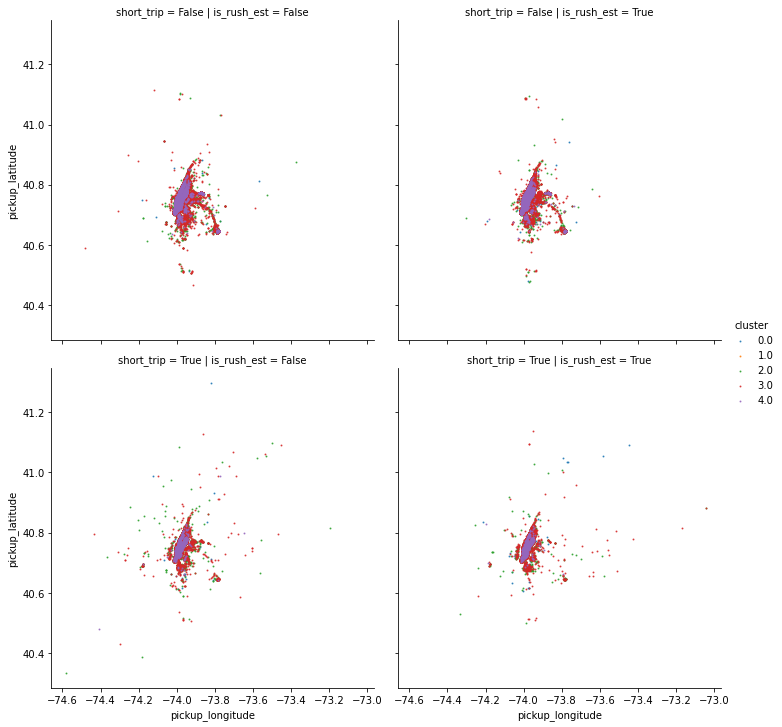

In [19]:
# Just take a subset to speed plotting
max_samples = 400000
gdf_head = taxi_gdf.iloc[:max_samples]
gdf_head["cluster"] = train_clusters_gpu[:max_samples]
gdf_head["short_trip"] = gdf_head["trip_distance"] < 1.01 # About the 25th percentile
gdf_head["is_rush_est"] = ((gdf_head.hour >= 10) & (gdf_head.hour <= 14)) | \
                                ((gdf_head.hour >= 21) & (gdf_head.hour <= 24))

# actually do the plot
sns.lmplot("pickup_longitude", "pickup_latitude", data=gdf_head.to_pandas(),
           hue="cluster", col="is_rush_est", row="short_trip", fit_reg=False, scatter_kws={"s": 0.9})

# Pick a Training Set

Let's imagine we want to be able predict fare prices based on the available data. We'll start by splitting the data into train and test subsets.

In [21]:
%%time
from sklearn.model_selection import train_test_split as sk_train_test_split

X_np = taxi_df.drop(columns='fare_amount').to_numpy()
Y_np = taxi_df[["fare_amount"]].to_numpy()

X_train_np, X_test_np, Y_train_np, Y_test_np = sk_train_test_split(X_np, Y_np, test_size=0.2)

# Clean up memory
X_np = None
Y_np = None
taxi_df = None

CPU times: user 18.2 ms, sys: 3.78 ms, total: 22 ms
Wall time: 21.8 ms


In [22]:
%%time
from cuml.preprocessing.model_selection import train_test_split as cu_train_test_split

X_gpu = taxi_gdf.drop(columns='fare_amount').values.astype("float32")
Y_gpu = taxi_gdf[["fare_amount"]].values.astype("float32")

X_col_names = taxi_gdf.columns.tolist()
X_col_names.remove('fare_amount')

X_train_gpu, X_test_gpu, Y_train_gpu, Y_test_gpu = cu_train_test_split(X_gpu,
                                                                        Y_gpu,
                                                                        test_size=0.2)

CPU times: user 220 ms, sys: 113 ms, total: 333 ms
Wall time: 736 ms


# Fit a simple supervised model with cuML

cuML supports a large range of supervised models, all emulating the scikit-learn interfaces. See the README (https://github.com/rapidsai/cuml) for a recent list. Here, we'll try a very simple model - an ElasticNet regularized regression with both L1 and L2 regularization. As a user exercise, try replacing this with a RandomForestRegressor or a simpler LinearRegression.

In [23]:
from sklearn.linear_model import ElasticNet as skElasticNet

In [40]:
%%time
# Sklearn will parallelize over all CPU cores with n_jobs=-1
sk_model = skElasticNet(alpha=0.1)
sk_model.fit(X_train_np, Y_train_np)

CPU times: user 55.2 ms, sys: 7.92 ms, total: 63.1 ms
Wall time: 38.6 ms


ElasticNet(alpha=0.1)

In [41]:
from sklearn.metrics.regression import r2_score as sk_r2_score

print("Out-of-sample (test) R2: ", sk_r2_score(Y_test_np, sk_model.predict(X_test_np)))

Out-of-sample (test) R2:  0.8940068697913633


In [42]:
%%time

# TODO: Build a similar model on GPU with cuML

# *** Answer:
from cuml.linear_model import ElasticNet as cuElasticNet
cu_model = cuElasticNet(alpha=0.1)
cu_model.fit(X_train_gpu, Y_train_gpu)

CPU times: user 293 ms, sys: 11.8 ms, total: 305 ms
Wall time: 303 ms


ElasticNet(alpha=0.1, l1_ratio=0.5, fit_intercept=True, normalize=False, max_iter=1000, tol=0.001, selection='cyclic', handle=<cuml.raft.common.handle.Handle object at 0x7f0d98cdb310>, output_type='cupy', verbose=4)

In [43]:
%%time

# TODO: Predict on the test set and evaluate the predictions' R2 score

# *** Answer
from cuml.metrics.regression import r2_score

Y_hat_gpu = cu_model.predict(X_test_gpu)
r2_score(Y_test_gpu, Y_hat_gpu)

CPU times: user 13.9 ms, sys: 76 µs, total: 14 ms
Wall time: 13.4 ms


0.7630497217178345

# Demo 5: Train an  XGBoost Regression Model

XGBoost is one of the most popular packages for gradient boosted decision trees. It comes with excellent GPU acceleration out of the box.

In [28]:
%%time
# Train on CPU (uses all CPUs by default)
import xgboost

params = {
 'learning_rate': 0.3,
  'max_depth': 6,

  'subsample': 0.6,
  'gamma': 1
}

train_dmat = xgboost.DMatrix(X_train_np, Y_train_np, feature_names=X_col_names)
print("Converted to dmatrix")
trained_model = xgboost.train(params, train_dmat, num_boost_round=5)

Converted to dmatrix
CPU times: user 1.72 s, sys: 26.6 ms, total: 1.74 s
Wall time: 945 ms


In [29]:
%%time

# TODO: retrain on GPU for more rounds, saving model as trained_model_gpus

# *** Answer:
params = {
 'learning_rate': 0.3,
  'max_depth': 6,
  'tree_method': 'gpu_hist',
  'subsample': 0.6,
  'gamma': 1
}

train_dmat = xgboost.DMatrix(X_train_gpu, Y_train_gpu, feature_names=X_col_names)
print("Converted to dmatrix")
trained_model_gpu = xgboost.train(params, train_dmat, num_boost_round=50)

Converted to dmatrix
CPU times: user 10.5 s, sys: 868 ms, total: 11.4 s
Wall time: 11.3 s


# How Good is Our Model?

Now that we have a trained model, we need to test it with the ecords we held out.Y_train_gpu

In [35]:
%%time

# TODO: generate predictions on the test set as Y_test_prediction

# *** Answer:
# Note that we can pass in a cuDF dataframe without conversion
test_dmat = xgboost.DMatrix(X_test_gpu, feature_names=X_col_names)

Y_test_prediction = trained_model_gpu.predict(test_dmat)

CPU times: user 94.8 ms, sys: 11.9 ms, total: 107 ms
Wall time: 105 ms


# Compute Root Mean Squared Error

In [39]:
# TODO: compute RMSE

# *** Answer:

Y_test_asnumpy = Y_test_gpu.get().flatten()
sq_err = (Y_test_prediction - Y_test_asnumpy)**2
np.sqrt(sq_err.mean())

2.1651425

# Save Trained Model for Later Use

To make a model maximally useful, you need to be able to save it for later use.

In [32]:
# Save model
trained_model_gpu.save_model("output.model")